In [1]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parent))
from runs import find_runs  # noqa: E402

In [2]:
location_error = pd.DataFrame()
velocity_error = pd.DataFrame()
velocity_error_relative = pd.DataFrame()

# Iterate over all runs
for run_path in find_runs(working_dir.parent / "runs" / "euler_explicit"):
    # Read parameters.json
    with open(run_path / "parameters.json") as file:
        parameters = json.load(file)

    # Calculate mean L2 error norm for each timestep
    location_error_data = []
    velocity_error_data = []
    velocity_error_relative_data = []
    indices = []
    for timestep_path in (run_path / "solution").glob("*_particles_*.pvtu"):
        mesh = pv.read(timestep_path)

        # Calculate error norm for each particle
        mesh["location_error"] = np.linalg.norm(
            mesh.points - mesh["analytical_location"], axis=1
        )

        # For the velocity, we calculate the relative error
        mesh["velocity_error"] = np.linalg.norm(
            mesh["velocity"] - mesh["analytical_velocity"], axis=1
        )
        mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
            mesh["analytical_velocity"], axis=1
        )

        # Calculate median error norm over all particles
        location_error_data.append(mesh["location_error"].mean())
        velocity_error_data.append(mesh["velocity_error"].mean())
        velocity_error_relative_data.append(np.median(mesh["velocity_error_relative"]))

        # Use the timestep number from the filename as index
        indices.append(int(timestep_path.stem.split("_")[-1]))

    # Generate descriptive column name
    column_name = {
        "nearest-neighbor": "NN",
        "rbf-pum-direct": "RBF",
    }[parameters["mapping"]]

    if parameters["mapping"] == "rbf-pum-direct":
        column_name += (
            "_"
            + {
                "compact-polynomial-c0": "CP0",
                "compact-polynomial-c2": "CP2",
                "compact-polynomial-c4": "CP4",
                "compact-polynomial-c6": "CP6",
                "compact-polynomial-c8": "CP8",
            }[parameters["basis_function"]]
        )

        column_name += f"_{parameters['support_radius']}"

    column_name += f"_{parameters['refinement']}"

    # Insert into DataFrame
    location_error[column_name] = pd.Series(data=location_error_data, index=indices)
    velocity_error[column_name] = pd.Series(data=velocity_error_data, index=indices)
    velocity_error_relative[column_name] = pd.Series(
        data=velocity_error_relative_data, index=indices
    )

/tmp/ipykernel_12718/4206548009.py:28: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_12718/4206548009.py:28: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_12718/4206548009.py:28: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_12718/4206548009.py:28: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_12718/4206548009.py:28: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_12718/4206548009.py:28: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linal

In [3]:
# Sort columns by name
location_error.sort_index(inplace=True, axis=1)
velocity_error.sort_index(inplace=True, axis=1)
velocity_error_relative.sort_index(inplace=True, axis=1)

# Sort rows by timestep number
location_error.sort_index(inplace=True, axis=0)
velocity_error.sort_index(inplace=True, axis=0)
velocity_error_relative.sort_index(inplace=True, axis=0)

In [4]:
velocity_error.filter(like="NN", axis=1).describe()

,NN_2,NN_3,NN_4,NN_5,NN_6,NN_7
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,0.167854,0.089416,0.043989,0.022027,0.011013,0.005494
std,0.085066,0.043180,0.021620,0.010827,0.005420,0.002710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100303,0.056641,0.025764,0.013248,0.006535,0.003277
50%,0.176306,0.095906,0.046833,0.023780,0.011874,0.005981
75%,0.233697,0.130144,0.065207,0.032677,0.016220,0.008145
max,0.300957,0.151481,0.071633,0.035921,0.018571,0.009142


In [5]:
velocity_error.filter(like="RBF_CP4", axis=1).describe()

,RBF_CP4_0.5_2,RBF_CP4_0.5_3,RBF_CP4_0.5_4,RBF_CP4_0.5_5,RBF_CP4_0.5_6,RBF_CP4_0.5_7
count,401.000000,401.000000,401.000000,401.000000,401.000000,4.010000e+02
mean,0.071541,0.007034,0.000396,0.000058,0.000007,6.457975e-07
std,0.037662,0.003259,0.000199,0.000028,0.000003,3.155027e-07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.045677,0.004728,0.000231,0.000039,0.000004,3.944799e-07
50%,0.062843,0.007527,0.000438,0.000063,0.000008,6.987539e-07
75%,0.105761,0.009954,0.000573,0.000084,0.000010,9.111959e-07
max,0.131275,0.011577,0.000696,0.000103,0.000012,1.132796e-06


In [6]:
velocity_error.filter(like="RBF_CP8", axis=1).describe()

,RBF_CP8_0.5_2,RBF_CP8_0.5_3,RBF_CP8_0.5_4,RBF_CP8_0.5_5,RBF_CP8_0.5_6,RBF_CP8_0.5_7
count,401.000000,401.000000,401.000000,401.000000,4.010000e+02,4.010000e+02
mean,0.140501,0.008567,0.000410,0.000019,6.668343e-07,1.936997e-08
std,0.080946,0.003947,0.000206,0.000009,3.237987e-07,9.384037e-09
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.069468,0.005844,0.000227,0.000012,4.138272e-07,1.155034e-08
50%,0.142111,0.009186,0.000470,0.000020,7.431055e-07,2.157670e-08
75%,0.218041,0.011957,0.000578,0.000027,9.418139e-07,2.736455e-08
max,0.256257,0.014346,0.000670,0.000034,1.135868e-06,3.332788e-08


array([<Axes: xlabel='timestep'>, <Axes: xlabel='timestep'>,
       <Axes: xlabel='timestep'>], dtype=object)

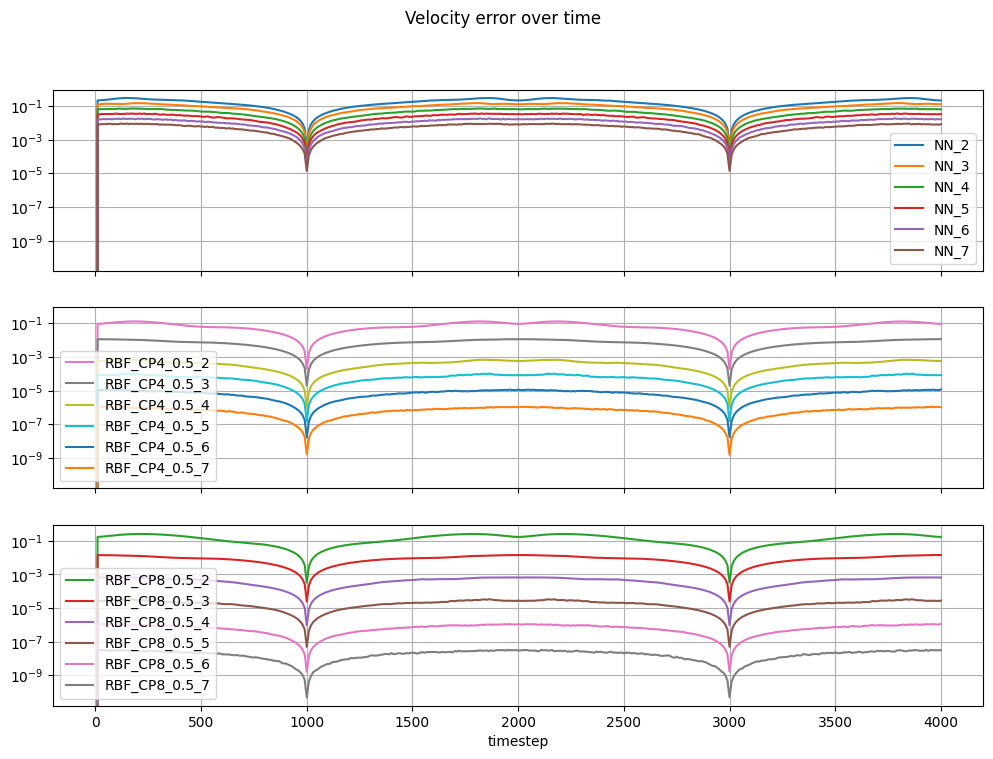

In [8]:
velocity_error.filter(
    axis=1,
    items=[
        "NN_2",
        "NN_3",
        "NN_4",
        "NN_5",
        "NN_6",
        "NN_7",
        "RBF_CP4_0.5_2",
        "RBF_CP4_0.5_3",
        "RBF_CP4_0.5_4",
        "RBF_CP4_0.5_5",
        "RBF_CP4_0.5_6",
        "RBF_CP4_0.5_7",
        "RBF_CP8_0.5_2",
        "RBF_CP8_0.5_3",
        "RBF_CP8_0.5_4",
        "RBF_CP8_0.5_5",
        "RBF_CP8_0.5_6",
        "RBF_CP8_0.5_7",
    ],
).plot(
    title="Velocity error over time",
    figsize=(12, 8),
    grid=True,
    xlabel="timestep",
    logy=True,
    sharey=True,
    subplots=[
        (
            "NN_2",
            "NN_3",
            "NN_4",
            "NN_5",
            "NN_6",
            "NN_7",
        ),
        (
            "RBF_CP4_0.5_2",
            "RBF_CP4_0.5_3",
            "RBF_CP4_0.5_4",
            "RBF_CP4_0.5_5",
            "RBF_CP4_0.5_6",
            "RBF_CP4_0.5_7",
        ),
        (
            "RBF_CP8_0.5_2",
            "RBF_CP8_0.5_3",
            "RBF_CP8_0.5_4",
            "RBF_CP8_0.5_5",
            "RBF_CP8_0.5_6",
            "RBF_CP8_0.5_7",
        ),
    ],
)